In [1]:
import matplotlib.pyplot as plt
import h5py
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz

In [2]:
def read_solar_S_hdf5(file_path):
    with h5py.File(file_path, 'r') as f:
        r_over_R = np.array(f['/r_over_R'])
        c_s = np.array(f['/c_s'])
        Gamma_1 = np.array(f['/Gamma_1'])
        T0 = np.array(f['/T'])
        rho0 = np.array(f['/rho'])
        p0 = np.array(f['/p'])
        
        r_over_R = np.flip(r_over_R)
        c_s = np.flip(c_s)
        Gamma_1 = np.flip(Gamma_1)
        T0 = np.flip(T0)
        rho0 = np.flip(rho0)
        p0 = np.flip(p0)

    return r_over_R, c_s, Gamma_1, T0, rho0, p0

r_over_R, c_s, Gamma_1, T0, rho0, p0\
    =read_solar_S_hdf5("./solar_s.h5")

In [3]:
#pick a start point and end point for the model
starting_point = 0.65
end_point = 0.95
starting_index = np.where(r_over_R>=starting_point)[0][0]

In [4]:
#calculate gravity
R_sun = 6.957e10 # [cgs]
G = 6.6743e-8 # [cgs]
M = 4*np.pi*R_sun**3 * cumtrapz(rho0*(r_over_R)**2, r_over_R, initial=0)
g = np.zeros(len(M))
g[1:] = G * M[1:] /(r_over_R[1:]**2 * R_sun**2)

In [5]:
#choose reference variables at starting point
rho_b = rho0[starting_index]
p0_b = p0[starting_index]
g_b = g[starting_index]
T0_b = T0[starting_index]
r_b = r_over_R[starting_index]
m_b = M[starting_index]

# Equations from project 2 AST3310

**Mass in infidesimal shell in numerator**
$$
\frac{\partial r}{\partial m} = \frac{1}{4\pi r^2\rho}
$$

**Hydrostatic equilibrium**
$$
\frac{\partial P}{\partial m} = -\frac{Gm}{4\pi r^4}
$$

**Not using this**
$$
\frac{\partial L}{\partial m} = \varepsilon
$$

**For now I have $P_{total}=P_{gas}$**
$$
P = P_{rad}+P_{gas}
$$

**Derive this**
$$
\frac{\partial T}{\partial m} = \nabla \frac{T}{P}\frac{\partial P}{\partial m}=-\nabla \frac{T}{P} \frac{Gm}{4\pi r^4}
$$

## Writing eqs in terms of $\partial/\partial r$ instead

$$
\frac{\partial m}{\partial r} = 4\pi r^2\rho
$$

$$
\frac{\partial P}{\partial r} = -\frac{Gm(r)}{r^2}\rho
$$

$$
\frac{\partial T}{\partial r} = \nabla \frac{T}{P}\frac{\partial P}{\partial r}
$$

We use the ideal gas law for 

$$
\rho=\frac{m_u\mu}{k_B}\frac{P}{T}
$$

In [13]:
def k(r):
    # for now setting k as constant in radiative and convective zone
    if (r>=0.7*R_sun):
        return 0.45
    if r<0.7*R_sun:
        return 0

def get_nabla(r):
    nabla_ad = 0.4
    nabla_star = nabla_ad + k(r)
    return nabla_star, nabla_ad

In [14]:
mu = 1 #mean molecular weight, setting this as 1 for now, just hydrogen
m_u = 1.66053907e-24 # atomic mass constant [g]
k_B = 1.3807e-16 # boltzmann constant [cm2 g s-2 K-1]

N = 1000
r_end = 1

r = np.linspace(r_b, r_end, N) * R_sun #need to make sure this fits with von neumann
P = np.zeros(N)
rho = np.zeros(N)
T = np.zeros(N)
m = np.zeros(N)

P[0] = p0_b
rho[0] = rho_b
T[0] = T0_b
m[0] = m_b

def get_dY_dr(r, m, P, T, rho):
    #rhs of diffeqs
    nabla_star, nabla_ad = get_nabla(r)
    
    dm_dr = 4 * np.pi * r**2 *rho
    dP_dr = - G * m /(r**2) * rho
    dT_dr = nabla_star * T/P * dP_dr    
    return [dm_dr, dP_dr, dT_dr]

#solving diffeqs
for i in range(0, N-1):
    dY_dr = get_dY_dr(r[i], m[i], P[i], T[i], rho[i])
    dr = r[i+1]-r[i]
    
    m[i+1] = m[i] + dY_dr[0] * dr
    P[i+1] = P[i] + dY_dr[1] * dr
    T[i+1] = T[i] + dY_dr[2] * dr
    
    rho[i+1] = m_u * mu / k_B * P[i+1]/T[i+1] #ideal gas law

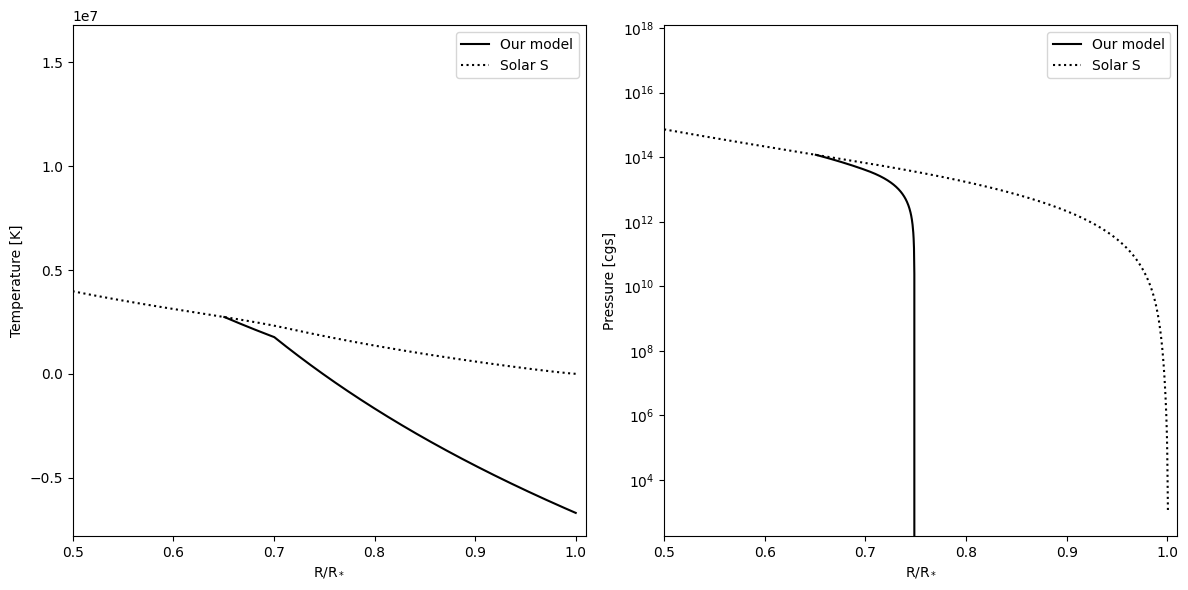

In [15]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
ax[0].set_xlim(0.5,1.01)
ax[0].set_xlabel("R/R$_*$")
ax[0].set_ylabel("Temperature [K]")

ax[0].plot(r/R_sun, T, color="black", label="Our model")
ax[0].plot(r_over_R, T0, color="black", linestyle=":", label="Solar S")
ax[0].legend()

ax[1].set_xlim(0.5,1.01)
ax[1].set_xlabel("R/R$_*$")
ax[1].set_ylabel("Pressure [cgs]")

ax[1].semilogy(r/R_sun, P, color="black", label="Our model")
ax[1].semilogy(r_over_R, p0, color="black", linestyle=":", label="Solar S")
ax[1].legend()

fig.tight_layout()
plt.show()

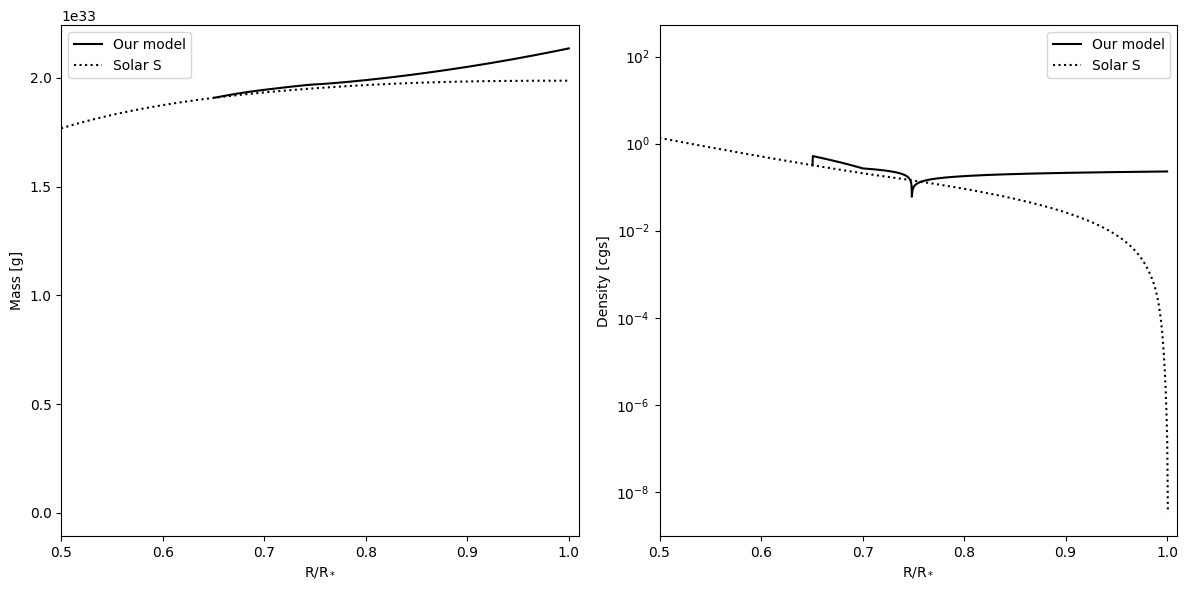

In [16]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
ax[0].set_xlim(0.5,1.01)
ax[0].set_xlabel("R/R$_*$")
ax[0].set_ylabel("Mass [g]")

ax[0].plot(r/R_sun, m, color="black", label="Our model")
ax[0].plot(r_over_R, M, color="black", linestyle=":", label="Solar S")
ax[0].legend()

ax[1].set_xlim(0.5,1.01)
ax[1].set_xlabel("R/R$_*$")
ax[1].set_ylabel("Density [cgs]")

ax[1].semilogy(r/R_sun, rho, color="black", label="Our model")
ax[1].semilogy(r_over_R, rho0, color="black", linestyle=":", label="Solar S")
ax[1].legend()

fig.tight_layout()
plt.show()

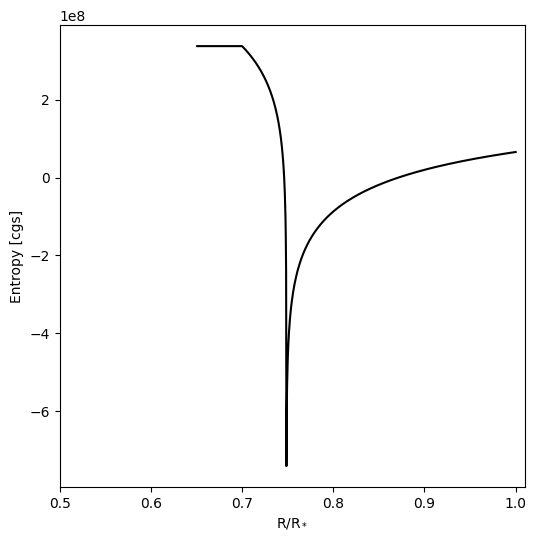

In [17]:
gamma = 5/3

#Lantz after eq (10) 
r_star = P[0]/(rho[0]*T[0])
#Lantz after eq (72)
c_p = r_star/(1-1/gamma)

s = np.zeros(N)
s[0] = c_p

#entropy calculation
for i in range(0, N-1):
    dr = r[i+1]-r[i]
    
    H = - dr*P[i+1]/(P[i+1]-P[i])
    
    #Lantz after eq (10) 
    r_star = P[i+1]/(rho[i+1]*T[i+1])
    #Lantz after eq (72)
    c_p = r_star/(1-1/gamma)
    
    nabla_star, nabla_ad = get_nabla(r[i+1])
    superad_param = nabla_star - nabla_ad
    
    ds_dr = - c_p/H * superad_param
    
    s[i+1] = s[i] + ds_dr * dr

fig, ax = plt.subplots(figsize=(6,6))
ax.set_xlim(0.5,1.01)
ax.set_xlabel("R/R$_*$")
ax.set_ylabel("Entropy [cgs]")

ax.plot(r/R_sun, s, color="black")
plt.show()